# Seminar: Regularization Comparing

Regularization techniques are essential in machine learning and deep learning to prevent overfitting, improve model generalization, and enhance training stability.

Today we will compare the regularization methods using the example of a simple MNIST handwritten digit classification network. We will compare BatchNorm, Dropout, L1 and L2 norms.

Author: [Ivan Nasonov](https://www.linkedin.com/in/ivan-nasonov/)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Let's set the batch size for our datasets

In [ ]:
batch_size = 64

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Let's talk about types of regularizations

### Batch Normalization

Batch Normalization (BatchNorm) is a technique to improve the training of deep neural networks. It normalizes the inputs of each layer so that they have a mean of zero and a variance of one. This normalization is done for each mini-batch, hence the name. The key benefits of BatchNorm include:


* Stabilizing Learning: By normalizing the inputs to each layer, BatchNorm reduces the internal covariate shift, which stabilizes the learning process.
* Higher Learning Rates: It allows the use of higher learning rates, which can speed up the training process.
* Regularization Effect: It has a slight regularization effect, reducing the need for other forms of regularization like Dropout.
* Improved Gradient Flow: It helps in maintaining the gradient flow through the network, which is particularly beneficial for very deep networks.


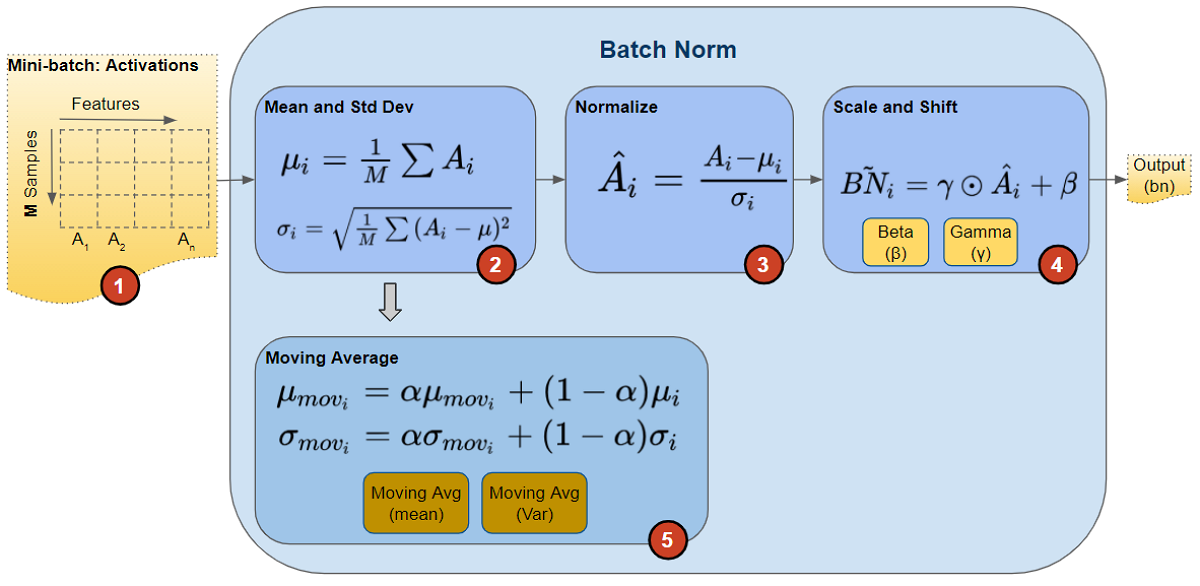

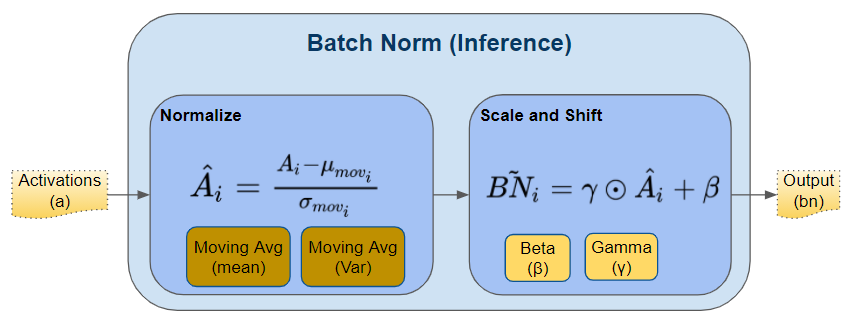

### Dropout

Dropout is a regularization technique used to prevent overfitting in neural networks. During training, Dropout randomly sets a fraction of the input units to zero at each update step. The key aspects of Dropout include:


* Preventing Overfitting: By randomly dropping units, Dropout prevents the network from becoming too reliant on any particular set of features.
* Model Averaging: It can be seen as a form of model averaging, where different subsets of the network are trained at different times.
* Implementation: Dropout is typically applied to the fully connected layers of a network, but it can also be used in convolutional layers.
* Hyperparameter: The dropout rate (the fraction of units to drop) is a hyperparameter that needs to be tuned.

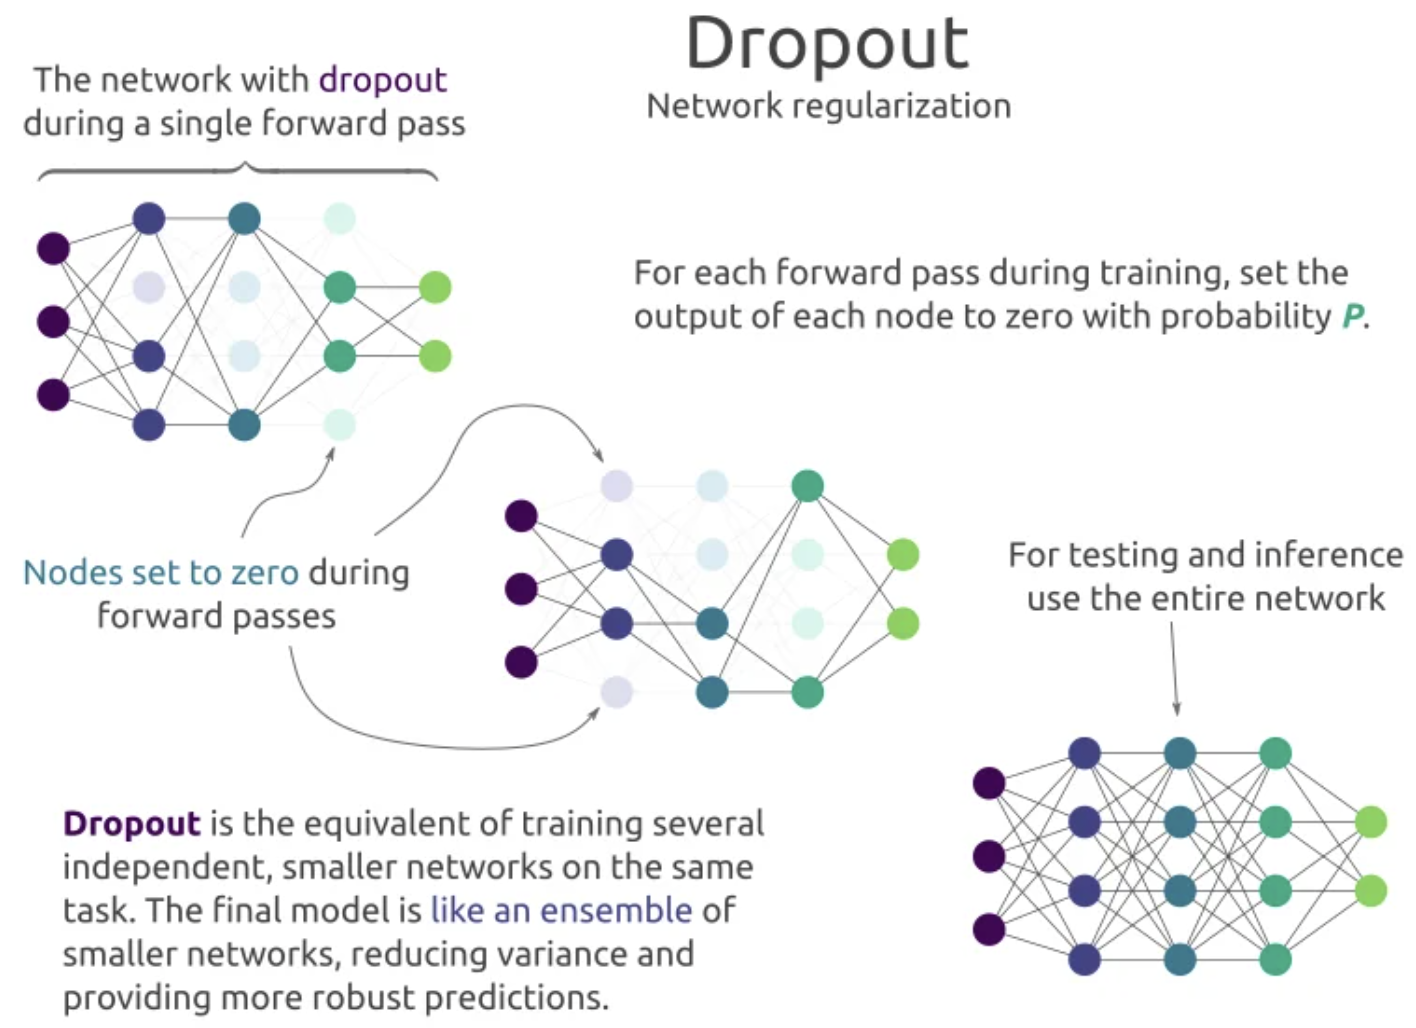

### L1 and L2 norms

L1 regularization, also known as Lasso regularization, adds a penalty equal to the absolute value of the magnitude of coefficients to the loss function.

L2 regularization, also known as Ridge regularization, adds a penalty equal to the square of the magnitude of coefficients to the loss function.

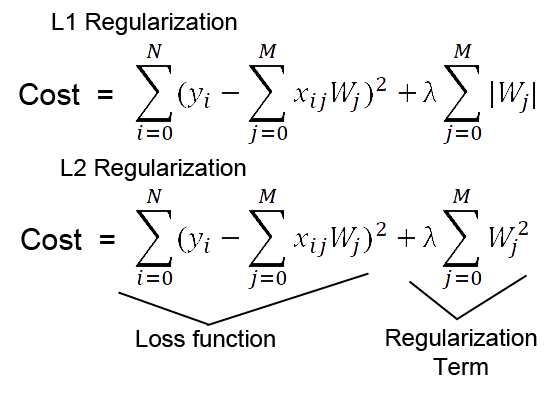

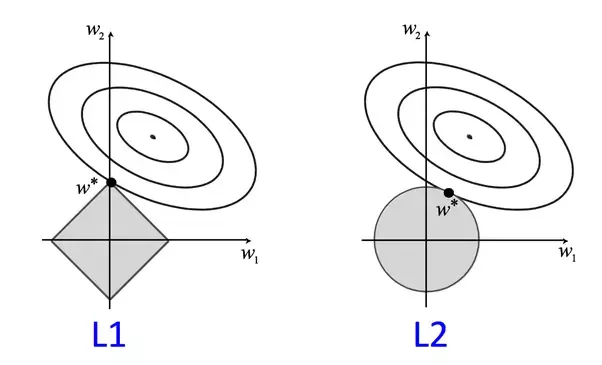

We write a simple NN with flexible regularizations methods.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, use_batchnorm=False, use_dropout=False, l1_lambda=0.0, l2_lambda=0.0):
        super(SimpleNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256) if use_batchnorm else nn.Identity()
        self.dropout1 = nn.Dropout(0.3) if use_dropout else nn.Identity()

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128) if use_batchnorm else nn.Identity()
        self.dropout2 = nn.Dropout(0.3) if use_dropout else nn.Identity()

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

    def l1_penalty(self):
        l1_norm = sum(p.abs().mean() for p in self.parameters())
        return self.l1_lambda * l1_norm

    def l2_penalty(self):
        l2_norm = sum(p.pow(2.0).mean() for p in self.parameters())
        return self.l2_lambda * l2_norm

Training loop

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) + model.l1_penalty() + model.l2_penalty()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)

Test function

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

Set the configurations of our regularizations

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# configs for experiments
configs = [
    {"use_batchnorm": False, "use_dropout": False, "l1_lambda": 0.0, "l2_lambda": 0.0, "label": "No Regularization"},
    {"use_batchnorm": True, "use_dropout": False, "l1_lambda": 0.0, "l2_lambda": 0.0, "label": "BatchNorm"},
    {"use_batchnorm": False, "use_dropout": True, "l1_lambda": 0.0, "l2_lambda": 0.0, "label": "Dropout"},
    {"use_batchnorm": False, "use_dropout": False, "l1_lambda": 0.1, "l2_lambda": 0.0, "label": "L1 Regularization"},
    {"use_batchnorm": False, "use_dropout": False, "l1_lambda": 0.0, "l2_lambda": 0.1, "label": "L2 Regularization"},
]

results = {}

In [ ]:
learning_rate = 0.01
num_epochs = 10

In [ ]:
for config in configs:
    model = SimpleNN(use_batchnorm=config["use_batchnorm"], use_dropout=config["use_dropout"],
                      l1_lambda=config["l1_lambda"], l2_lambda=config["l2_lambda"]).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        test_loss, test_accuracy = test(model, device, test_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Config: {config["label"]}, Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

    results[config["label"]] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

Config: No Regularization, Epoch: 1, Train Loss: 1.0057, Train Acc: 0.7507, Test Loss: 0.4218, Test Acc: 0.8762
Config: No Regularization, Epoch: 2, Train Loss: 0.3788, Train Acc: 0.8915, Test Loss: 0.3369, Test Acc: 0.8997
Config: No Regularization, Epoch: 3, Train Loss: 0.3207, Train Acc: 0.9062, Test Loss: 0.2926, Test Acc: 0.9139
Config: No Regularization, Epoch: 4, Train Loss: 0.2864, Train Acc: 0.9162, Test Loss: 0.2595, Test Acc: 0.9253
Config: No Regularization, Epoch: 5, Train Loss: 0.2595, Train Acc: 0.9238, Test Loss: 0.2541, Test Acc: 0.9238
Config: No Regularization, Epoch: 6, Train Loss: 0.2358, Train Acc: 0.9308, Test Loss: 0.2230, Test Acc: 0.9354
Config: No Regularization, Epoch: 7, Train Loss: 0.2152, Train Acc: 0.9373, Test Loss: 0.2029, Test Acc: 0.9402
Config: No Regularization, Epoch: 8, Train Loss: 0.1965, Train Acc: 0.9435, Test Loss: 0.1862, Test Acc: 0.9449
Config: No Regularization, Epoch: 9, Train Loss: 0.1805, Train Acc: 0.9476, Test Loss: 0.1726, Test Acc:

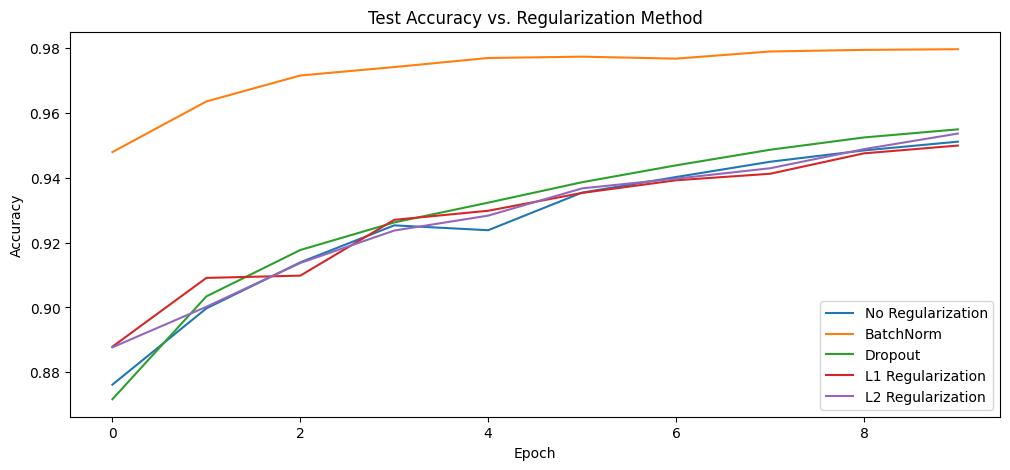

In [ ]:
plt.figure(figsize=(12, 5))
for label, result in results.items():
    plt.plot(result["test_accuracies"], label=label)
plt.title('Test Accuracy vs. Regularization Method')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

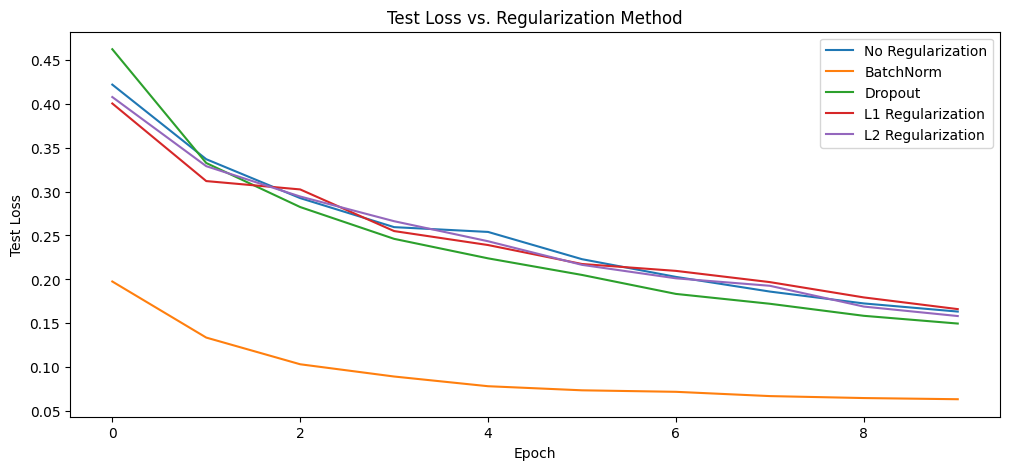

In [ ]:
plt.figure(figsize=(12, 5))
for label, result in results.items():
    plt.plot(result["test_losses"], label=label)
plt.title('Test Loss vs. Regularization Method')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.show()